In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import numpy as np
import awkward as ak

In [2]:
# This program plots the transverse mass of MET and a third lepton, where the third lepton is associated with a lepton pair that has the same flavor, opposite charge, and closest mass to 91.2.

class DibosonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "MET and Third Lepton")
        muon_axis = hist.Bin("massT", "Transverse Mass", 50, 15, 2000)
        
        self._accumulator = processor.dict_accumulator({
            'massT': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df["dataset"]

        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content
            )
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content,
            eta=df['Electron_eta'].content,
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            charge=df['Electron_charge'].content
            )
        # We can also construct a jagged array for our MET to bundle pt and phi together.
        MET = ak.JaggedArray.fromcounts(np.ones(muons.size, dtype=np.uint64), ak.Table({'pt': df['MET_pt'], 'phi': df['MET_phi']}))

        
        # This function gets us a Boolean array which highlights the mass in a sublist that is closest to 91.2
        def closest(masses):
            delta = abs(91.2 - masses)
            closest_masses = delta.min()
            is_closest = (delta == closest_masses)
            return is_closest

        # This function gets us a Boolean array which highlights the mass in a sublist that is highest. 
        def highest(pt):
            highest_pt = pt.max()
            is_highest = (pt == highest_pt)
            return is_highest

        # This function calculates the transverse mass of MET and the third lepton in a triplet.
        def transverse(MET_pts, MET_phis, third_p4):
            theta = abs(MET_phis - third_p4.phi)
            massT = np.sqrt(2 * MET_pts * third_p4.pt * (1 - np.cos(theta)))
            return massT

        # This function removes redundant (repeated) elements of a triplet, i.e. ((1, 2), 1) or ((1, 2), 2).
        def rmDuplicates(triplet):
            pair = triplet.i0
            third = triplet.i1
            return triplet[np.not_equal(pair.i0.p4, third.p4) & np.not_equal(pair.i1.p4, third.p4)]

        
        # Selects events that have exactly 3 leptons. We have to keep muons and electrons separate.
        three_leptons = (muons.counts + electrons.counts) >= 3
        # The (& pt > -1) here keeps jaggedness. False statements result in [] in place of elements, instead of dropping them. This keeps our lepton arrays consistent in size and indexing. We'll use it throughout this exercise, but that's all it's doing!
        muons_3lep = muons[three_leptons & (muons.pt > -1)]
        electrons_3lep = electrons[three_leptons & (electrons.pt > -1)]

        # There are four possible combinations of 3 leptons: (ee)m (mm)e (ee)e (mm)m. eem and mme are easy: we choose two from e's and m's, and cross it with the other. Now we have a single ((e, e), m), a tuple with a pair and an extra lepton.
        eem = electrons_3lep.choose(2).cross(muons_3lep)
        mme = muons_3lep.choose(2).cross(electrons_3lep)
        # eee and mmm are harder, but we can start by choosing two and crossing with itself.
        eee = electrons_3lep.choose(2).cross(electrons_3lep)
        mmm = muons_3lep.choose(2).cross(muons_3lep)
        # Unfortunately, this has redundant elements: ((1, 2), 1) for instance. So we check that the 3rd lepton is not in the pair.
        eee = rmDuplicates(eee)
        mmm = rmDuplicates(mmm)

        # Check opposite charge.
        opp_eem = eem[eem.i0.i0.charge != eem.i0.i1.charge]
        opp_mme = mme[mme.i0.i0.charge != mme.i0.i1.charge]
        opp_eee = eee[eee.i0.i0.charge != eee.i0.i1.charge]
        opp_mmm = mmm[mmm.i0.i0.charge != mmm.i0.i1.charge]

        # Check which pair(s) have mass closest to 91.2.
        closest_eem = opp_eem[closest(opp_eem.i0.mass)]
        closest_mme = opp_mme[closest(opp_mme.i0.mass)]
        closest_eee = opp_eee[closest(opp_eee.i0.mass)]
        closest_mmm = opp_mmm[closest(opp_mmm.i0.mass)]
        
        # Finally, if there's still more than one triplet, get the one with the highest third-lepton pt.
        final_eem = closest_eem[highest(closest_eem.i1.pt)]
        final_mme = closest_mme[highest(closest_mme.i1.pt)]
        final_eee = closest_eee[highest(closest_eee.i1.pt)]
        final_mmm = closest_mmm[highest(closest_mmm.i1.pt)]

        # Now we just need to get the associated METs. We've preserved jaggedness so far, so this isn't too difficult. The above should give us a list of sublists each containing one triplet. If we cross this with MET, we'll get something fairly clunk, but for our purposes, it'll work just fine: (MET, ((e, e), e)). We don't need our pair anymore, so the relatively complex accessibility to it is luckily irrelevant.
        MET_eem = MET.cross(final_eem.i1.p4)
        MET_mme = MET.cross(final_mme.i1.p4)
        MET_eee = MET.cross(final_eee.i1.p4)
        MET_mmm = MET.cross(final_mmm.i1.p4)

        # Use the transverse function above to calculate the transverse mass between MET and each combination.
        eem_massT = transverse(MET_eem.i0['pt'], MET_eem.i0['phi'], MET_eem.i1).content
        mme_massT = transverse(MET_mme.i0['pt'], MET_mme.i0['phi'], MET_mme.i1).content
        eee_massT = transverse(MET_eee.i0['pt'], MET_eee.i0['phi'], MET_eee.i1).content
        mmm_massT = transverse(MET_mmm.i0['pt'], MET_mmm.i0['phi'], MET_mmm.i1).content

        # Put together all the transverse masses into one array.
        massT = np.concatenate((eem_massT, mme_massT, eee_massT, mmm_massT))
        
        output['massT'].fill(dataset=dataset, massT=massT)
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'massT': ["data/Run2012B_SingleMu.root"]}
output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=DibosonProcessor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 1000000)

Processing: 100%|██████████| 54/54 [08:00<00:00,  6.80s/items]


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (massT) instance at 0x7fe4ce95d470>: [<matplotlib.collections.PolyCollection at 0x7fe53224a668>],
  'legend': <matplotlib.legend.Legend at 0x7fe53224a940>})

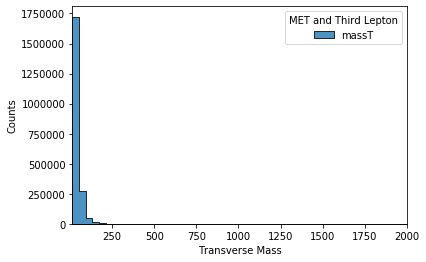

In [4]:
hist.plot1d(output['massT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)